<a href="https://colab.research.google.com/github/vincentbriat/Super-resolution-investigation/blob/main/Knowledge_distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [26]:
from os import listdir, environ, path
import sys
from pathlib import Path
import pandas as pd
from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import cv2 as cv 
from sklearn.decomposition import PCA
import numpy as np
from google.colab import drive
import random as rd
import csv
from torchsummary import summary
import matplotlib.pyplot as plt
!pip install basicsr
from basicsr.archs.rrdbnet_arch import RRDBNet

!pip install pytorch-msssim
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

drive.mount('/content/drive/')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [27]:
# Making sure to use the gpu, if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_device(torch.device(0))

In [28]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, use_act: bool, **kwargs):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
    self.activation = nn.LeakyReLU(.2, inplace=True) if use_act else nn.Identity()

  def forward(self, x):
    return self.activation(self.conv(x))

class RDB(nn.Module):
  def __init__(self, in_channels, middle_channels = 32, residual_scale = .2):
    super().__init__()
    self.residual_scale = residual_scale
    self.block = nn.ModuleList([ConvBlock(in_channels + i * middle_channels,
                                  middle_channels if i<4 else in_channels,
                                  3,
                                  stride=1,
                                  padding=1,
                                  use_act=i<4) for i in range(5)])


  def forward(self, x):
    input = x
    for conv in self.block:
      out = conv(input)
      input = torch.cat([input, out], dim=1)
    return self.residual_scale * out + x

class RRDB(nn.Module):
  def __init__(self, in_channels, mid_channels = 32, residual_scale = .2):
    super().__init__()
    self.residual_scale = residual_scale
    self.model = nn.Sequential(*[RDB(in_channels, middle_channels = mid_channels, residual_scale = residual_scale) for _ in range(3)])
  
  def forward(self, x):
    return self.model(x) * self.residual_scale + x

class Head(nn.Module):
  def __init__(self, out_channels = 64) -> None:
    super().__init__()
    self.model = nn.Conv2d(3, out_channels, 3, stride=1, padding=1)

  def forward(self, x):
    return self.model(x)

class Tail(nn.Module):
  def __init__(self, in_channels = 64) -> None:
    super().__init__()
    self.model = nn.Sequential(nn.Conv2d(in_channels, 256, 3, stride=1, padding=1),
                               nn.Upsample(scale_factor=4, mode='nearest'),
                               nn.LeakyReLU(.2, inplace=True),
                               nn.Conv2d(256, 3, 3, stride=1, padding=1))
  
  def forward(self, x):
    return self.model(x)

# Knowledge Distillation Setup

In [29]:
class Student(nn.Module):
  def __init__(self, nb_of_bodies = 16) -> None:
    super().__init__()
    self.head = Head(32)
    self.nb_of_bodies = nb_of_bodies
    self.bodies = nn.ModuleList([RRDB(32) for _ in range(self.nb_of_bodies)])
    self.post_body_conv = nn.Conv2d(32, 32, 3, stride=1, padding=1)
    self.tail = Tail(32)
    self.loss_fn = nn.L1Loss()
    self.opt = torch.optim.SGD(self.parameters(), lr=0.1)
    self.scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=10, gamma=0.5)
    self.training_bodies = 1
  
  def forward(self, x: torch.Tensor):
    output = self.head(x)
    for i in range(self.training_bodies):
      output = self.bodies[i](output)
    output = self.head(x) + self.post_body_conv(output)
    return self.tail(output)

  def train(self, output_generator: torch.Tensor, output_teacher: torch.Tensor):
    super().train()
    output_student = self(output_generator)
    return self.learn(output_student, output_teacher)

  def loss(self, output_student, output_teacher):
    return self.loss_fn(output_student, output_teacher)
    
  def learn(self, output_student: torch.Tensor, output_teacher: torch.Tensor):
    loss = self.loss(output_student, output_teacher)
    self.opt.zero_grad()
    loss.backward()
    self.opt.step()
    return loss

  def initialize_csv(self, path):
    self.record(path, ['Epoch', 'Loss'])

  def record(self, path, row):
    with open(path, 'a', newline='') as f:
      csv.writer(f).writerow(row)
    print("Student recorded Successfully!")
  
  def load(self, path):
    saved_info = torch.load(path)
    self.load_state_dict(saved_info['model_state_dict'])
    self.opt.load_state_dict(saved_info['optimizer_state_dict'])
    self.scheduler.load_state_dict(saved_info['lr_scheduler_state_dict'])
    self.loss_fn = saved_info['loss_fn']

  def save(self, path):
    torch.save({'model_state_dict': self.state_dict(), 'optimizer_state_dict': self.opt.state_dict(), 'loss_fn': self.loss_fn, 'lr_scheduler_state_dict': self.scheduler.state_dict()}, path)
    print("Student saved Successfully!")

In [30]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(nn.Conv2d(1,64,3), nn.Conv2d(64, 3, 5))
    self.loss_fn = nn.L1Loss()
    self.opt = torch.optim.SGD(self.parameters(), lr=1e-5)
    self.scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=10, gamma=0.5)
    self.weight_r = 1.
  
  def forward(self, x: torch.Tensor):
    return self.model(x)

  def loss(self, output_student, output_teacher, output_generator):
    loss_gen = -torch.log(self.loss_fn(output_student, output_teacher) + 1)
    loss_r = self.loss_fn(output_generator, torchvision.transforms.Resize(output_generator.shape[-2:])(output_teacher))
    return loss_gen + self.weight_r * loss_r

  def train(self, output_generator: torch.Tensor, output_teacher: torch.Tensor, output_student: torch.Tensor):
    super().train()

    loss = self.loss()

    self.opt.zero_grad()
    loss.backward()
    self.opt.step()
    return loss

  def initialize_csv(self, path):
    self.record(path, ['Epoch', 'Loss'])

  def record(self, path, row):
    with open(path, 'a', newline='') as f:
      csv.writer(f).writerow(row)
    print("Generator recorded Successfully!")
  
  def load(self, path):
    saved_info = torch.load(path)
    self.load_state_dict(saved_info['model_state_dict'])
    self.opt.load_state_dict(saved_info['optimizer_state_dict'])
    self.scheduler.load_state_dict(saved_info['lr_scheduler_state_dict'])
    self.loss_fn = saved_info['loss_fn']

  def save(self, path):
    torch.save({'model_state_dict': self.state_dict(), 'optimizer_state_dict': self.opt.state_dict(), 'loss_fn': self.loss_fn, 'lr_scheduler_state_dict': self.scheduler.state_dict()}, path)
    print("Generator saved Successfully!")

In [42]:
class Knowledge_Distillation:
  def __init__(self, student: nn.Module, teacher: nn.Module, generator: nn.Module, iterations: int = 120, imitation_steps: int = 50, height: int = 120, width: int = 120, batch_size: int = 2):
    # Different bodies for the progressive training
    self.student = student
    self.teacher = teacher
    self.generator = generator
    self.cur_epoch = 0
    self.imitation_steps = imitation_steps
    self.batch_size = batch_size
    self.height = height
    self.width = width
    self.iterations = iterations
    
    self.teacher.requires_grad_(False)

    # The various S_i are as follows S_tail(Body_i...Body_0(S_head))
  
  def train(self, epochs: int, student_model_path: str, student_records_path: str, generator_model_path: str, generator_records_path: str):
    if (not Path(student_records_path).is_file()):
      self.student.initialize_csv(student_records_path)
    
    if (not Path(generator_records_path).is_file()):
      self.generator.initialize_csv(generator_records_path)

    while self.cur_epoch < epochs:
      print(f'\n*********Epoch {self.cur_epoch}/{epochs}*********\n')
      
      for iteration in range(self.iterations):
        print(f'Iteration {iteration}/{self.iterations}')

        # Student training

        self.generator.requires_grad_(False)

        for k in range(self.imitation_steps):
          print(f'Imitation step {k}/{self.imitation_steps}')

          noise_images = torch.rand((self.batch_size, 1, self.height, self.width))
          generated_images = self.generator(noise_images)
          teacher_output = self.teacher(generated_images)
          loss = self.student.train(generated_images, teacher_output)
          print(loss.item())

        self.student.scheduler.step()
        self.generator.requires_grad_()

        if (student_model_path):
          self.student.save(student_model_path)
        
        # Generator training

        print('\nGenerator training')
        self.student.requires_grad_(False)

        noise_images = torch.rand((self.batch_size, 1, self.height, self.width))
        generated_images = self.generator(noise_images)
        teacher_output = self.teacher(generated_images)
        student_output = self.student(generated_images)

        loss = self.generator.train(generated_images, teacher_output, student_output)
        print(loss.item())
        
        self.generator.scheduler.step()
        self.student.requires_grad_()

        if (generator_records_path):
          self.generator.save(generator_model_path)

        loss_student, loss_generator = self.test()
        self.generator.record(generator_records_path, [self.cur_epoch, loss_generator])
        self.student.record(student_records_path, [self.cur_epoch, loss_student])

      self.cur_epoch += 1

  # Trains all bodies from scratch

  def train_all_bodies(self, **kwargs):
    for i in range(1, self.student.nb_of_bodies + 1):
      self.student.training_bodies = i
      self.train(kwargs['epoch'])

  # This function tests both the student and generator models.
  # It outputs a tuple with both losses (student_loss, generator_loss)

  def test(self, batches = 50):
    cum_loss_student, cum_loss_generator = 0, 0
    for batch in range(batches):
      print(f'Batch {batch+1}/{batches}')
      noise_input = torch.rand((self.batch_size, 1, self.height, self.width))
      generated_images = self.generator(noise_input)
      teacher_out = self.teacher(generated_images)
      student_out = self.student(generated_images)
      cum_loss_student += self.student.loss(student_out, teacher_out).item()
      cum_loss_generator += self.generator.loss(student_out, teacher_out, generated_images).item()
    return cum_loss_student / batches, cum_loss_generator / batches

# ESRGAN

In [ ]:
# Original code for ESRGAN:
# https://github.com/xinntao/ESRGAN/blob/master/RRDBNet_arch.py

import functools
import torch
import torch.nn as nn
import torch.nn.functional as F


def make_layer(block, n_layers):
    layers = []
    for _ in range(n_layers):
        layers.append(block())
    return nn.Sequential(*layers)


class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        # mutil.initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x


class RRDB(nn.Module):
    '''Residual in Residual Dense Block'''

    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x


class RRDBNet(nn.Module):
    def __init__(self, in_nc, out_nc, nf, nb, gc=32):
        super(RRDBNet, self).__init__()
        RRDB_block_f = functools.partial(RRDB, nf=nf, gc=gc)

        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB_block_f, nb)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        #### upsampling
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(fea))
        fea = fea + trunk

        fea = self.lrelu(self.upconv1(F.interpolate(fea, scale_factor=2, mode='nearest')))
        fea = self.lrelu(self.upconv2(F.interpolate(fea, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.HRconv(fea)))

        return out

In [ ]:
teacher = RRDBNet(3, 3, 64, 23, gc=32)
teacher.load_state_dict(torch.load('drive/MyDrive/ML/Indiv_Project/Second_Year/KD/ESRGAN_models/RealESRGAN_x4plus.pth'))
teacher.to(device)

RuntimeError: ignored

ESRGAN

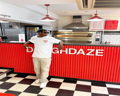

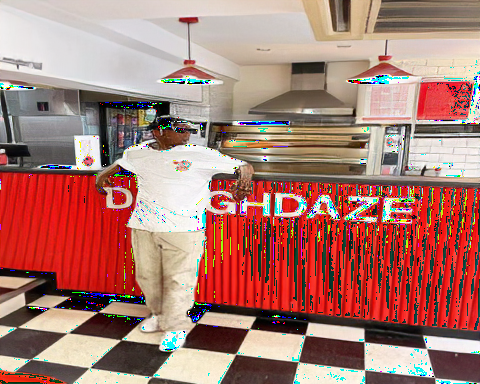

In [ ]:
input_image = Image.open('benji.jpg').resize((120, 96))
display(input_image)
input_tensor = torchvision.transforms.ToTensor()(input_image).unsqueeze(0).to(device)
out_tensor = teacher(input_tensor)
out_tensor.to('cpu')
display(torchvision.transforms.ToPILImage()(out_tensor[0]))

ESRResNet

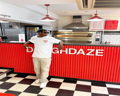

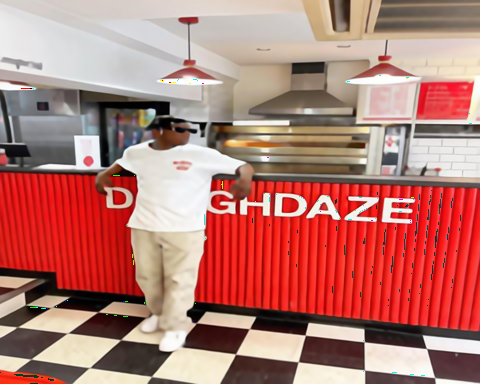

In [ ]:
input_image = Image.open('benji.jpg').resize((120, 96))
display(input_image)
input_tensor = torchvision.transforms.ToTensor()(input_image).unsqueeze(0).to(device)
out_tensor = teacher(input_tensor)
out_tensor.to('cpu')
display(torchvision.transforms.ToPILImage()(out_tensor[0]))

# Real ESRGAN

In [16]:
# https://github.com/xinntao/Real-ESRGAN/blob/5ca1078535923d485892caee7d7804380bfc87fd/realesrgan/utils.py

from torch.nn import functional as F
import cv2
import math
import numpy as np
import os
import queue
import threading

class RealESRGANer():
    """A helper class for upsampling images with RealESRGAN.
    Args:
        scale (int): Upsampling scale factor used in the networks. It is usually 2 or 4.
        model_path (str): The path to the pretrained model.
        model (nn.Module): The defined network. Default: None.
        tile (int): As too large images result in the out of GPU memory issue, so this tile option will first crop
            input images into tiles, and then process each of them. Finally, they will be merged into one image.
            0 denotes for do not use tile. Default: 0.
        tile_pad (int): The pad size for each tile, to remove border artifacts. Default: 10.
        pre_pad (int): Pad the input images to avoid border artifacts. Default: 10.
        half (bool): Whether to use half precision during inference. Default: False.
    """

    def __init__(self,
                 model_path,
                 tile=0,
                 tile_pad=10,
                 pre_pad=10,
                 half=False,
                 device=None,
                 gpu_id=None):
        self.tile_size = tile
        self.tile_pad = tile_pad
        self.pre_pad = pre_pad
        self.mod_scale = None
        self.half = half

        self.scale = 4

        # initialize model
        if gpu_id:
            self.device = torch.device(
                f'cuda:{gpu_id}' if torch.cuda.is_available() else 'cpu') if device is None else device
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') if device is None else device

        loadnet = torch.load(model_path, map_location=torch.device('cpu'))

        # prefer to use params_ema
        if 'params_ema' in loadnet:
            keyname = 'params_ema'
        else:
            keyname = 'params'
        
        model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
        model.load_state_dict(loadnet[keyname], strict=True)

        model.eval()
        self.model = model.to(self.device)
        if self.half:
            self.model = self.model.half()

    def dni(self, net_a, net_b, dni_weight, key='params', loc='cpu'):
        """Deep network interpolation.
        ``Paper: Deep Network Interpolation for Continuous Imagery Effect Transition``
        """
        net_a = torch.load(net_a, map_location=torch.device(loc))
        net_b = torch.load(net_b, map_location=torch.device(loc))
        for k, v_a in net_a[key].items():
            net_a[key][k] = dni_weight[0] * v_a + dni_weight[1] * net_b[key][k]
        return net_a

    def pre_process(self, img):
        """Pre-process, such as pre-pad and mod pad, so that the images can be divisible
        """
        img = torch.from_numpy(np.transpose(img, (2, 0, 1))).float()
        self.img = img.unsqueeze(0).to(self.device)
        if self.half:
            self.img = self.img.half()

        # pre_pad
        if self.pre_pad != 0:
            self.img = F.pad(self.img, (0, self.pre_pad, 0, self.pre_pad), 'reflect')
        # mod pad for divisible borders
        if self.scale == 2:
            self.mod_scale = 2
        elif self.scale == 1:
            self.mod_scale = 4
        if self.mod_scale is not None:
            self.mod_pad_h, self.mod_pad_w = 0, 0
            _, _, h, w = self.img.size()
            if (h % self.mod_scale != 0):
                self.mod_pad_h = (self.mod_scale - h % self.mod_scale)
            if (w % self.mod_scale != 0):
                self.mod_pad_w = (self.mod_scale - w % self.mod_scale)
            self.img = F.pad(self.img, (0, self.mod_pad_w, 0, self.mod_pad_h), 'reflect')

    def process(self):
        # model inference
        self.output = self.model(self.img)

    def tile_process(self):
        """It will first crop input images to tiles, and then process each tile.
        Finally, all the processed tiles are merged into one images.
        Modified from: https://github.com/ata4/esrgan-launcher
        """
        batch, channel, height, width = self.img.shape
        output_height = height * self.scale
        output_width = width * self.scale
        output_shape = (batch, channel, output_height, output_width)

        # start with black image
        self.output = self.img.new_zeros(output_shape)
        tiles_x = math.ceil(width / self.tile_size)
        tiles_y = math.ceil(height / self.tile_size)

        # loop over all tiles
        for y in range(tiles_y):
            for x in range(tiles_x):
                # extract tile from input image
                ofs_x = x * self.tile_size
                ofs_y = y * self.tile_size
                # input tile area on total image
                input_start_x = ofs_x
                input_end_x = min(ofs_x + self.tile_size, width)
                input_start_y = ofs_y
                input_end_y = min(ofs_y + self.tile_size, height)

                # input tile area on total image with padding
                input_start_x_pad = max(input_start_x - self.tile_pad, 0)
                input_end_x_pad = min(input_end_x + self.tile_pad, width)
                input_start_y_pad = max(input_start_y - self.tile_pad, 0)
                input_end_y_pad = min(input_end_y + self.tile_pad, height)

                # input tile dimensions
                input_tile_width = input_end_x - input_start_x
                input_tile_height = input_end_y - input_start_y
                tile_idx = y * tiles_x + x + 1
                input_tile = self.img[:, :, input_start_y_pad:input_end_y_pad, input_start_x_pad:input_end_x_pad]

                # upscale tile
                try:
                    with torch.no_grad():
                        output_tile = self.model(input_tile)
                except RuntimeError as error:
                    print('Error', error)
                print(f'\tTile {tile_idx}/{tiles_x * tiles_y}')

                # output tile area on total image
                output_start_x = input_start_x * self.scale
                output_end_x = input_end_x * self.scale
                output_start_y = input_start_y * self.scale
                output_end_y = input_end_y * self.scale

                # output tile area without padding
                output_start_x_tile = (input_start_x - input_start_x_pad) * self.scale
                output_end_x_tile = output_start_x_tile + input_tile_width * self.scale
                output_start_y_tile = (input_start_y - input_start_y_pad) * self.scale
                output_end_y_tile = output_start_y_tile + input_tile_height * self.scale

                # put tile into output image
                self.output[:, :, output_start_y:output_end_y,
                            output_start_x:output_end_x] = output_tile[:, :, output_start_y_tile:output_end_y_tile,
                                                                       output_start_x_tile:output_end_x_tile]

    def post_process(self):
        # remove extra pad
        if self.mod_scale is not None:
            _, _, h, w = self.output.size()
            self.output = self.output[:, :, 0:h - self.mod_pad_h * self.scale, 0:w - self.mod_pad_w * self.scale]
        # remove prepad
        if self.pre_pad != 0:
            _, _, h, w = self.output.size()
            self.output = self.output[:, :, 0:h - self.pre_pad * self.scale, 0:w - self.pre_pad * self.scale]
        return self.output

    @torch.no_grad()
    def enhance(self, img: np.array, alpha_upsampler='realesrgan'):
        h_input, w_input = img.shape[0:2]
        # img: numpy
        img = img.astype(np.float32)
        if np.max(img) > 256:  # 16-bit image
            max_range = 65535
            print('\tInput is a 16-bit image')
        else:
            max_range = 255
        img = img / max_range
        if len(img.shape) == 2:  # gray image
            img_mode = 'L'
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:  # RGBA image with alpha channel
            img_mode = 'RGBA'
            alpha = img[:, :, 3]
            img = img[:, :, 0:3]
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if alpha_upsampler == 'realesrgan':
                alpha = cv2.cvtColor(alpha, cv2.COLOR_GRAY2RGB)
        else:
            img_mode = 'RGB'
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # ------------------- process image (without the alpha channel) ------------------- #
        self.pre_process(img)
        if self.tile_size > 0:
            self.tile_process()
        else:
            self.process()
        output_img = self.post_process()
        output_img = output_img.data.squeeze().float().cpu().clamp_(0, 1).numpy()
        output_img = np.transpose(output_img[[2, 1, 0], :, :], (1, 2, 0))
        if img_mode == 'L':
            output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2GRAY)

        # ------------------- process the alpha channel if necessary ------------------- #
        if img_mode == 'RGBA':
            print('Processing alpha channel:----------------')
            if alpha_upsampler == 'realesrgan':
                self.pre_process(alpha)
                if self.tile_size > 0:
                    self.tile_process()
                else:
                    self.process()
                output_alpha = self.post_process()
                output_alpha = output_alpha.data.squeeze().float().cpu().clamp_(0, 1).numpy()
                output_alpha = np.transpose(output_alpha[[2, 1, 0], :, :], (1, 2, 0))
                output_alpha = cv2.cvtColor(output_alpha, cv2.COLOR_BGR2GRAY)
            else:  # use the cv2 resize for alpha channel
                h, w = alpha.shape[0:2]
                output_alpha = cv2.resize(alpha, (w * self.scale, h * self.scale), interpolation=cv2.INTER_LINEAR)

            # merge the alpha channel
            output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2BGRA)
            output_img[:, :, 3] = output_alpha

        # ------------------------------ return ------------------------------ #
        if max_range == 65535:  # 16-bit image
            output = (output_img * 65535.0).round().astype(np.uint16)
        else:
            output = (output_img * 255.0).round().astype(np.uint8)

        return output


class PrefetchReader(threading.Thread):
    """Prefetch images.
    Args:
        img_list (list[str]): A image list of image paths to be read.
        num_prefetch_queue (int): Number of prefetch queue.
    """

    def __init__(self, img_list, num_prefetch_queue):
        super().__init__()
        self.que = queue.Queue(num_prefetch_queue)
        self.img_list = img_list

    def run(self):
        for img_path in self.img_list:
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            self.que.put(img)

        self.que.put(None)

    def __next__(self):
        next_item = self.que.get()
        if next_item is None:
            raise StopIteration
        return next_item

    def __iter__(self):
        return self


class IOConsumer(threading.Thread):

    def __init__(self, opt, que, qid):
        super().__init__()
        self._queue = que
        self.qid = qid
        self.opt = opt

    def run(self):
        while True:
            msg = self._queue.get()
            if isinstance(msg, str) and msg == 'quit':
                break

            output = msg['output']
            save_path = msg['save_path']
            cv2.imwrite(save_path, output)
        print(f'IO worker {self.qid} is done.')

In [17]:
teacher = RealESRGANer('drive/MyDrive/ML/Indiv_Project/Second_Year/KD/ESRGAN_models/RealESRGAN_x4plus.pth', tile=600)
# teacher.enhance(numpy_img)

# Post-processing: Clamp VS Normalization

In [19]:
input_image = Image.open('benji.jpg').resize((150,120))
display(input_image)
input_tensor = torchvision.transforms.ToTensor()(input_image).unsqueeze(0).to(device)
# The output should be restricted between 0 and 1 before being turned into an image
# This is performed in enhance()
out_tensor = teacher.model(input_tensor)
out_tensor.to('cpu')
display(torchvision.transforms.ToPILImage()(out_tensor[0]))

FileNotFoundError: ignored

In [ ]:
input_image = Image.open('benji.jpg').resize((150,120))
display(input_image)
# input_tensor = torchvision.transforms.ToTensor()(input_image).unsqueeze(0).to(device)
out_tensor = teacher.enhance(np.array(input_image))
# out_tensor.to('cpu')
display(Image.fromarray(out_tensor))

In [ ]:
input_image = Image.open('benji.jpg')
display(input_image)
# input_tensor = torchvision.transforms.ToTensor()(input_image).unsqueeze(0).to(device)
out_tensor = teacher.enhance(np.array(input_image))
# out_tensor.to('cpu')
display(Image.fromarray(out_tensor).resize(input_image.size))

In [ ]:
input_image = Image.open('Vincent_insta_pro.png')
display(input_image)
# input_tensor = torchvision.transforms.ToTensor()(input_image).unsqueeze(0).to(device)
out_tensor = teacher.enhance(np.array(input_image))
# out_tensor.to('cpu')
# display(Image.fromarray(out_tensor).resize(input_image.size))

In [ ]:
display(Image.fromarray(out_tensor).resize(input_image.size))

# Training

In [32]:
gene = Generator()
student = Student()
teacher = RealESRGANer('drive/MyDrive/ML/Indiv_Project/Second_Year/KD/ESRGAN_models/RealESRGAN_x4plus.pth', tile=600)
student.training_bodies = 16
summary(student, (3,48,48), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             896
              Head-2           [-1, 32, 48, 48]               0
            Conv2d-3           [-1, 32, 48, 48]           9,248
         LeakyReLU-4           [-1, 32, 48, 48]               0
         ConvBlock-5           [-1, 32, 48, 48]               0
            Conv2d-6           [-1, 32, 48, 48]          18,464
         LeakyReLU-7           [-1, 32, 48, 48]               0
         ConvBlock-8           [-1, 32, 48, 48]               0
            Conv2d-9           [-1, 32, 48, 48]          27,680
        LeakyReLU-10           [-1, 32, 48, 48]               0
        ConvBlock-11           [-1, 32, 48, 48]               0
           Conv2d-12           [-1, 32, 48, 48]          36,896
        LeakyReLU-13           [-1, 32, 48, 48]               0
        ConvBlock-14           [-1, 32,

In [21]:
summary(teacher.model, (3,48,48), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           1,792
            Conv2d-2           [-1, 32, 48, 48]          18,464
         LeakyReLU-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 32, 48, 48]          27,680
         LeakyReLU-5           [-1, 32, 48, 48]               0
            Conv2d-6           [-1, 32, 48, 48]          36,896
         LeakyReLU-7           [-1, 32, 48, 48]               0
            Conv2d-8           [-1, 32, 48, 48]          46,112
         LeakyReLU-9           [-1, 32, 48, 48]               0
           Conv2d-10           [-1, 64, 48, 48]         110,656
ResidualDenseBlock-11           [-1, 64, 48, 48]               0
           Conv2d-12           [-1, 32, 48, 48]          18,464
        LeakyReLU-13           [-1, 32, 48, 48]               0
           Conv2d-14           [-1, 32

To train 1 body out of 16, 1 epoch takes 40 hours on CPU (approximately 2400 mins)

In [ ]:
student.training_bodies = 1
kd = Knowledge_Distillation(student, teacher.model, gene)

In [ ]:
kd.train(10)

In [ ]:
#teacher.requires_grad_(False)
#gene.requires_grad_(False)
input = torch.rand((1,480,480))
out = gene(input)
#display(torchvision.transforms.ToPILImage()(out))